In [1]:
# Warning: Execute this cell only once for the kernel. Reset the kernel if you need changes.
import sys
sys.path.append("../Python")
import ROOT as R
import time
import numpy as np
# Turn jsroot off if you want to make a pdf from this file.
%jsroot on
from root_helpers import SetStyle
R.EnableImplicitMT()                      # EnableImplicitMT must be called before the RDataFrame is constructed.

Welcome to JupyROOT 6.29/01


In [2]:
import os
recompile = True
try:
    if os.path.getmtime('Particles_C.so') - os.path.getmtime('../Python/Particles.C') > 0:
        recompile = False
        print("Recompile is not needed")
    else:
        print("Recompiling: ")
except:
    print("Recompile needed, file not found.")
if recompile:
    R.gROOT.LoadMacro("../Python/Particles.C++")
else:
    R.gROOT.LoadMacro("Particles_C.so")
R.Particles()

Recompile needed, file not found.


'Particles analysis. V1.0.3 \n'

Info in <TMacOSXSystem::ACLiC>: creating shared library /System/Volumes/Data/data/HPS/Analysis/PhysRun2021/./../Python/Particles_C.so


In [3]:
# Note: runs 14624 through 14673 are with Ebeam = 1.92 GeV. The rest is at 3.742 GeV
Ebeam = 3.742
ch = R.TChain("MiniDST")
Use_PreFiltered_Data = False

if not Use_PreFiltered_Data:
    #ch.Add("/data/HPS/data/physrun2021/pass0/minidst/hps_014722_000*.root")
    ch.Add("/data/HPS/data/physrun2021/pass0/minidst/hps_0147*.root")
    #ch.Add("/data/HPS/data/physrun2021/fee/*.root")
    print(f"Loaded {ch.GetEntries():,d} events ({ch.GetEntries():7.2e})")
    df = R.RDataFrame(ch)
    print("Available data names in Tuple:")
    ColumnNames=df.GetColumnNames()
    ll = 0
    pr_colnames = [x for x in ColumnNames if str(x).startswith('ecal')]
    for nn in pr_colnames:
        if ll < len(nn):
            ll = len(nn)
    for n in range(len(pr_colnames)):
        if n%4 == 0:
            print("")
        print(f"{str(pr_colnames[n]):{ll}s}",end="")

Loaded 36,587,663 events (3.66e+07)
Available data names in Tuple:

ecal_cluster_energy     ecal_cluster_hits       ecal_cluster_nhits      ecal_cluster_seed_energy
ecal_cluster_seed_index ecal_cluster_seed_ix    ecal_cluster_seed_iy    ecal_cluster_time       
ecal_cluster_x          ecal_cluster_y          ecal_cluster_z          ecal_hit_energy         
ecal_hit_index_x        ecal_hit_index_y        ecal_hit_time           

In [4]:
# Declare a local copy of the fiducial cut found in the Particle.C library, so we can easily manipulate the borders used.
if not hasattr(R,"is_in_fiducial_region"):
    R.gInterpreter.Declare("""
    bool is_in_fiducial_region(int ix, int iy){
        return(
               !(ix <= -23 || ix >= 23) && /* Cut out the left and right side */
               !(iy <= -5  || iy >= 5)  && /* Cut out the top and bottom row */
               !(iy >= -1  && iy <= 1)  && /* Cut out the first row around the gap */
               !(iy >= -2  && iy <= 2   && ix >= -11 && ix <= -1) && /* Cut around the photon hole */
               !(iy >=  4  && ix >= -19 && ix <= -17) && /* Cut around crystal (-18, 5) */
              // !(iy >=  1  && iy <= 3   && ix <= -21 ) &&   /* Cut around crystal (-23, 2) */
               !(iy >= 2   && iy <= 4 && ix >= -14 && ix <= -12 ) && /* Cut around crystal ( -13, 3) */
               !(iy >=  4               && ix >= 2 && ix <= 4)  /* Cut around crystal (3, 5) */
        );
    }
    """)

if not hasattr(R, "fid_cut"):
    R.gInterpreter.Declare("""
    RVec<bool> fid_cut(RVec<int> ix, RVec<int> iy){
        RVec<bool> out;
        for(size_t i=0;i< ix.size();++i){
            if(
               is_in_fiducial_region(ix[i], iy[i]) &&
               ( ix[i] < 0 )  /* Only electron side */
            ){
                out.push_back(true);
            }else{
                out.push_back(false);
            }
        }
        return out;
    }
    """)

if not Use_PreFiltered_Data:
    if 'n_clus' in ColumnNames:
        print("Data already has the additional information.")
        dfx = df
    else:
        dfx = df.Define("n_clus","ecal_cluster_energy.size()")\
                .Define("cluster_is_fiducial","fid_cut(ecal_cluster_seed_ix,ecal_cluster_seed_iy)")\
                .Define("ecs_ix_f","RVec<int> out;for(size_t i=0; i<cluster_is_fiducial.size();++i){ if(cluster_is_fiducial[i]) out.push_back(ecal_cluster_seed_ix[i]);}; return out;")\
                .Define("ecs_iy_f","RVec<int> out;for(size_t i=0; i<cluster_is_fiducial.size();++i){ if(cluster_is_fiducial[i]) out.push_back(ecal_cluster_seed_iy[i]);}; return out;")\
                .Define("ecal_tot_energy","double etot=0; for(size_t i=0; i<ecal_hit_energy.size();++i){ etot+= ecal_hit_energy[i]; } return etot;")\
                .Define("ecal_tot_clus_e","double etot=0; for(size_t i=0; i<ecal_cluster_energy.size();++i){ etot+= ecal_cluster_energy[i]; } return etot;") \
                .Define("ecal_tot_clus_e_fid","double etot=0; for(size_t i=0; i<ecal_cluster_energy.size();++i){ if(cluster_is_fiducial[i]){etot+= ecal_cluster_energy[i];} } return etot;") \
            .Define("ecal_tot_energy_fid","""
                double etot=0;
                for(size_t i=0; i<ecal_hit_energy.size();++i){
                    if(is_in_fiducial_region(ecal_hit_index_x[i],ecal_hit_index_y[i])) etot+= ecal_hit_energy[i];
                    }
                return etot;""")
        # Calculate the ecal cluster energy for clusters with a fiducial cut (limiting the region in the ECal), and a cut on the
        # number of hits in the cluster, plus a cut on the seed energy.

        dfx = dfx.Define("ec_e_f_np","""
            RVec<RVec<double>> out;
            for(int n=0;n<15;n++){
                RVec<double> ntmp;
                for(size_t i=0; i<cluster_is_fiducial.size();++i){
                    if( cluster_is_fiducial[i] &&
                        ecal_cluster_nhits[i] == n &&
                        ecal_cluster_seed_energy[i]>= 2. ){
                            ntmp.push_back(ecal_cluster_energy[i]);
                    }
                }
               out.push_back(ntmp);
            }
            return out;""")

        # Same, but without the cut on the number of hits.
        dfx = dfx.Define("ec_e_f","""
                RVec<double> out;
                for(size_t i=0; i<cluster_is_fiducial.size();++i){
                    if(cluster_is_fiducial[i]){out.push_back(ecal_cluster_energy[i]);}
                }
                return out;""")\
            .Define("ec_e_f_e","""
                RVec<double> out;
                for(size_t i=0; i<cluster_is_fiducial.size();++i){
                    if(cluster_is_fiducial[i] && ecal_cluster_seed_energy[i]>= 2.){out.push_back(ecal_cluster_energy[i]);}
                }
                return out;""")


        # dfx = dfx.Filter("n_clus == 1")
        pr_colnames.append("n_clus")
        pr_colnames.append("cluster_is_fiducial")
        pr_colnames.append("ecs_ix_f")
        pr_colnames.append("ecs_iy_f")
        pr_colnames.append("ecal_tot_energy")
        pr_colnames.append("ecal_tot_clus_e")
        pr_colnames.append("ecal_tot_energy_fid")
        pr_colnames.append("ec_e_f_np")
        pr_colnames.append("ec_e_f")
        pr_colnames.append("ec_e_f_e")
else:
    ch.Add("/data/HPS/data/physrun2021/pass0/minidst/Filtered_147xxx.root")
    dfx = R.RDataFrame(ch)
    print("Available data names in Tuple:")
    ColumnNames=dfx.GetColumnNames()
    ll = 0
    pr_colnames = [x for x in ColumnNames if str(x).startswith('')]
    for nn in pr_colnames:
        if ll < len(nn):
            ll = len(nn)
    for n in range(len(pr_colnames)):
        if n%4 == 0:
            print("")
        print(f"{str(pr_colnames[n]):{ll}s}",end="")
# dfx.Snapshot("MiniDST","Filtered_147xxx.root",pr_colnames)

In [5]:
h_ecal_tot_energy = dfx.Histo1D(("h_ecal_tot_energy","Ecal total hit energy",1000,0.,10.),"ecal_tot_energy")
h_ecal_tot_clus_e = dfx.Histo1D(("h_ecal_tot_clus_e","Ecal total cluster energy",1000,0.,10.),"ecal_tot_clus_e")
h_ecal_tot_clus_e_fid = dfx.Histo1D(("h_ecal_tot_clus_e_fid","Ecal total cluster energy, fid cut",1000,0.,10.),"ecal_tot_clus_e_fid")
h_ecal_tot_energy_fid = dfx.Histo1D(("h_ecal_tot_energy_fid","Ecal total hit energy, fid cut",1000,0.,10.),"ecal_tot_energy_fid")
h_ecal_diff_e = dfx.Define("diff","ecal_tot_energy - ecal_tot_clus_e").Histo1D(("h_ecal_diff_e","#Delta E #Sigma hits - #Sigma clusters",1000,-1.,1.),"diff")
h_ecal_diff_e_fid = dfx.Filter("ecal_tot_clus_e_fid>0").Define("diff","ecal_tot_energy_fid - ecal_tot_clus_e_fid").Histo1D(("h_ecal_diff_e_fid","#Delta E #Sigma hits - #Sigma clusters",1000,-1.,1.),"diff")
dfxx = dfx.Define("all_hits_in_fid","""
    for( size_t i=0; i< ecal_hit_index_x.size(); ++i){
        if( !is_in_fiducial_region(ecal_hit_index_x[i], ecal_hit_index_y[i]) ){
            return 0;
        }
    };
    return 1;""").Filter("all_hits_in_fid>0")
h_ecal_tot_energy_all = dfxx.Histo1D(("h_ecal_tot_energy","Ecal total hit energy",1000,0.,10.),"ecal_tot_energy")
h_ecal_tot_clus_e_all = dfxx.Histo1D(("h_ecal_tot_clus_e","Ecal total cluster energy",1000,0.,10.),"ecal_tot_clus_e")

h_ecal_diff_e_all = dfxx.Define("diff","ecal_tot_energy - ecal_tot_clus_e").Histo1D(("h_ecal_diff_e_all","#Delta E #Sigma hits - #Sigma clusters",1000,-1.,1.),"diff")

In [6]:
c00 = R.TCanvas("c00","Canvas1",1000,900)
c00.Divide(1,2)
p1 = c00.cd(1)
p1.SetLogy(0)
h_ecal_tot_energy.SetStats(0)
h_ecal_tot_energy.SetLineColor(R.kBlue)
h_ecal_tot_energy.Draw()
h_ecal_tot_clus_e.SetLineColor(R.kGreen)
h_ecal_tot_clus_e.Draw("same")
h_ecal_tot_energy_fid.SetLineColor(R.kRed)
h_ecal_tot_energy_fid.Draw("same")
h_ecal_tot_clus_e_fid.SetLineColor(R.kCyan)
h_ecal_tot_clus_e_fid.Draw("same")
h_ecal_tot_energy_all.SetLineColor(R.kOrange)
h_ecal_tot_energy_all.Draw("same")
h_ecal_tot_clus_e_all.SetLineColor(R.kBlack)
h_ecal_tot_clus_e_all.Draw("same")
leg1 = R.TLegend(0.65,0.7,0.9,0.9)
leg1.AddEntry(h_ecal_tot_energy.GetValue(), "Total Hit Energy")
leg1.AddEntry(h_ecal_tot_clus_e.GetValue(),"Total Cluster Energy")
leg1.AddEntry(h_ecal_tot_energy_fid.GetValue(),"Total Hit Energy in Fid region")
leg1.AddEntry(h_ecal_tot_clus_e_fid.GetValue(),"Total Cluster Energy, fid cut")
leg1.AddEntry(h_ecal_tot_energy_all.GetValue(),"Total Hit Energy all in Fid region.")
leg1.AddEntry(h_ecal_tot_clus_e_all.GetValue(),"Total Cluster E, all in fid.")
leg1.Draw()
p2 = c00.cd(2)
p2.SetLogy(0)
h_ecal_diff_e.SetLineColor(R.kBlue)
h_ecal_diff_e.Draw()
h_ecal_diff_e_fid.SetLineColor(R.kRed)
h_ecal_diff_e_fid.Draw("same")
h_ecal_diff_e_all.SetLineColor(R.kGreen)
h_ecal_diff_e_all.Draw("same")
c00.Draw()

In [5]:
n_clus = dfx.Histo1D(("n_clus", "Number of clusters in event, no cuts", 11, -0.5, 10.5), "n_clus")
h_n_clus_fid_e = dfx.Define("ncfe","ec_e_f_e.size()").Histo1D(("h_n_clus_fid_e","Num clusters in fiducial with E_{seed}>2.",11,-0.5,10.5),"ncfe")
h_n_clus_fid_e_1 = dfx.Filter("n_clus == 1").Define("ncfe","ec_e_f_e.size()").Histo1D(("h_n_clus_fid_e","Num clusters in fiducial with E_{seed}>2., n_clus==1",11,-0.5,10.5),"ncfe")
h_n_clus_fid_e_2 = dfx.Filter("n_clus == 2").Define("ncfe","ec_e_f_e.size()").Histo1D(("h_n_clus_fid_e","Num clusters in fiducial with E_{seed}>2., n_clus==2",11,-0.5,10.5),"ncfe")
#
# Filter the data on: at least one cluster in the fiducial region with a seed energy more than 2 GeV
# dfx = dfx.Filter("ec_e_f_e.size()>0")
# dfx.Snapshot("MiniDST", "Filtered_147xxx.root", pr_colnames)  # Write out the file.

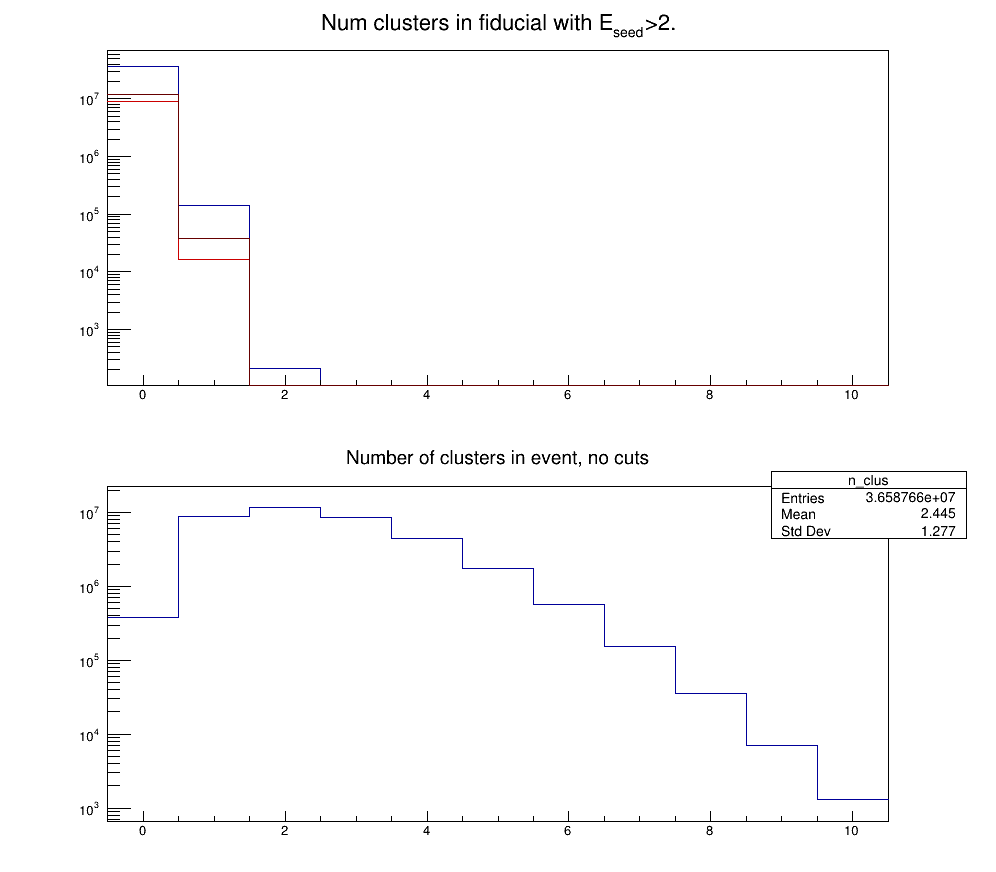

In [6]:
c01 = R.TCanvas("c01","Canvas1",1000,900)
c01.Divide(1,2)
p1 = c01.cd(1)
p1.SetLogy(1)
h_n_clus_fid_e.SetStats(0)
h_n_clus_fid_e.Draw()
h_n_clus_fid_e_1.SetLineColor(R.kRed+1)
h_n_clus_fid_e_1.Draw("same")
h_n_clus_fid_e_2.SetLineColor(R.kRed+3)
h_n_clus_fid_e_2.Draw("same")
p2 = c01.cd(2)
p2.SetLogy(1)
n_clus.Draw()
c01.Draw()

In [8]:
h_ecal_loc = dfx.Histo2D(("h_ecal_loc","Ecal cluster seed (ix,iy)",51,-25.5,25.5,13,-6.5,6.5),"ecal_cluster_seed_ix","ecal_cluster_seed_iy")
h_ecal_loc_fid = dfx.Histo2D(("h_ecal_loc","Ecal cluster seed (ix,iy)",51,-25.5,25.5,13,-6.5,6.5),"ecs_ix_f","ecs_iy_f")

In [9]:
h_ecal_tot_energy = dfx.Histo1D(("h_ecal_tot_energy","Ecal Total Hit Energy", 500, 0., 7.),"ecal_tot_energy")
h_ecal_tot_clus_e = dfx.Histo1D(("h_ecal_tot_clus_e","Ecal Total Cluster Energy", 500, 0., 7.),"ecal_tot_clus_e")
h_ecal_e_ratio = dfx.Define("ratio","ecal_tot_clus_e/ecal_tot_energy").Histo1D(("h_ecal_e_ratio","Ratio Ecal Tot Cluster E/Ecal Total Hit E", 500, 0., 7.),"ratio")
h_ecal_e_diff = dfx.Define("diff","ecal_tot_clus_e - ecal_tot_energy").Histo1D(("h_ecal_e_diff","Ecal Tot Cluster E - Ecal Total Hit E", 500, -5., 5.),"diff")


In [10]:
h_ecal_cluster_energy  = dfx.Histo1D(("h_ecal_cluster_energy", "Ecal Cluster Energy;E [GeV]", 300, 0., 5.), "ecal_cluster_energy")
h_ecal_cluster_energy_fid  = dfx.Histo1D(("h_ecal_cluster_energy_fid", "Ecal Cluster Energy;E [GeV]", 300, 0., 5.), "ec_e_f")
h_ecal_cluster_energy_fid_e  = dfx.Histo1D(("h_ecal_cluster_energy_fid_e", "Ecal Cluster Energy;E [GeV]", 300, 0., 5.), "ec_e_f_e")
# n_clus_1 = df_1.Histo1D(("n_clus_1","Number of clusters",11,-0.5,10.5),"n_clus")
#h_ecal_cluster_energy_1 = df_1.Histo1D(("h_ecal_cluster_energy_1","Ecal Cluster Energy;E [GeV]",300,0.,5.), "ecal_cluster_energy")
h_ecal_cluster_energy_fid_n = dfx.Filter("n_clus == 1").Histo1D(("h_ecal_cluster_energy_fid_n","Ecal Cluster Energy;E [GeV]",300,0.,5.), "ec_e_f")
h_ecal_cluster_energy_fid_n_e = dfx.Filter("n_clus == 1").Histo1D(("h_ecal_cluster_energy_fid_n_e","Ecal Cluster Energy;E [GeV]",300,0.,5.), "ec_e_f_e")

In [11]:
h_ecal_cluster_e_fid_np = []

for n in range(15):
    ecal_clus_e_with_cut = f"ec_e_f_np[{n}]"
    hist_name = f"h_ecal_cluster_e_fid_np{n}"
    h_ecal_cluster_e_fid_np.append(dfx.Define("ec_e",ecal_clus_e_with_cut).Histo1D((hist_name, "Ecal Cluster Energy;E [GeV]", 100, 0., 5.), "ec_e"))

h_ecal_cluster_nhits = dfx.Histo1D(("h_ecal_cluster_nhits","N cluster hits",21,-0.5,20.5),"ecal_cluster_nhits")
h_ecal_cluster_nhits_f = dfx.Define("nhits_f","RVec<int> out;for(size_t i=0; i<cluster_is_fiducial.size();++i){ if(cluster_is_fiducial[i]) out.push_back(ecal_cluster_nhits[i]);}; return out;")\
    .Histo1D(("h_ecal_cluster_nhits_f","N cluster hits, fid cut",21,-0.5,20.5),"nhits_f")
h_ecal_cluster_nhits_f_e = dfx.Define("nhits_f","RVec<int> out;for(size_t i=0; i<cluster_is_fiducial.size();++i){ if(cluster_is_fiducial[i] && ecal_cluster_seed_energy[i]>= 2.) out.push_back(ecal_cluster_nhits[i]);}; return out;")\
    .Histo1D(("h_ecal_cluster_nhits_f_e","N cluster hits, fid cut",21,-0.5,20.5),"nhits_f")
h_ecal_cluster_nhits_f_e_n = dfx.Filter("n_clus==1").Define("nhits_f","RVec<int> out;for(size_t i=0; i<cluster_is_fiducial.size();++i){ if(cluster_is_fiducial[i] && ecal_cluster_seed_energy[i]>= 2.) out.push_back(ecal_cluster_nhits[i]);}; return out;")\
    .Histo1D(("h_ecal_cluster_nhits_f_e","N cluster hits, fid cut",21,-0.5,20.5),"nhits_f")

h2d  = dfx.Define("ecs_ix_f_e","RVec<int> out;for(size_t i=0; i<cluster_is_fiducial.size();++i){ if(cluster_is_fiducial[i] && ecal_cluster_seed_energy[i]>= 2. && ecal_cluster_nhits[i] >= 9 ) out.push_back(ecal_cluster_seed_ix[i]);}; return out;")\
        .Define("ecs_iy_f_e","RVec<int> out;for(size_t i=0; i<cluster_is_fiducial.size();++i){ if(cluster_is_fiducial[i] && ecal_cluster_seed_energy[i]>= 2. && ecal_cluster_nhits[i] >= 9  ) out.push_back(ecal_cluster_seed_iy[i]);}; return out;")\
    .Histo2D(("h2d","Ecal cluster seed (ix,iy) w. cuts",51,-25.5,25.5,13,-6.5,6.5),"ecs_ix_f_e","ecs_iy_f_e")


In [12]:
dfx = dfx.Define("ec_e_f_np_x","""
    RVec<RVec<double>> out;
    for(int n=0;n<15;n++){
        RVec<double> ntmp;
        for(size_t i=0; i<cluster_is_fiducial.size();++i){
            if( cluster_is_fiducial[i] &&
                ecal_cluster_nhits[i] == n &&
                ecal_cluster_seed_energy[i]>= 2. &&
                !(ecal_cluster_seed_ix[i]>=-8 && ecal_cluster_seed_ix[i] <= -3 && abs(ecal_cluster_seed_iy[i])==3) ){
                    ntmp.push_back(ecal_cluster_energy[i]);
            }
        }
       out.push_back(ntmp);
    }
    return out;""")

h_ecal_cluster_e_fid_np_x = []
for n in range(15):
    ecal_clus_e_with_cut = f"ec_e_f_np_x[{n}]"
    hist_name = f"h_ecal_cluster_e_fid_np_x{n}"
    h_ecal_cluster_e_fid_np_x.append(dfx.Define("ec_e_x",ecal_clus_e_with_cut).Histo1D((hist_name, "Ecal Cluster Energy with cut;E [GeV]", 100, 0., 5.), "ec_e_x"))


# Analysis of runs 147xxx from 2021 data set.
The results below show the output for 244 files (partitions) from the pass 0 processing of runs 147xxx: 14700, 14701, 14702, 14706, 14709, 14722, 14726, 14728, 14729, 14730, 14731, 14734, 14736



Execution time:  2.3944 secs.


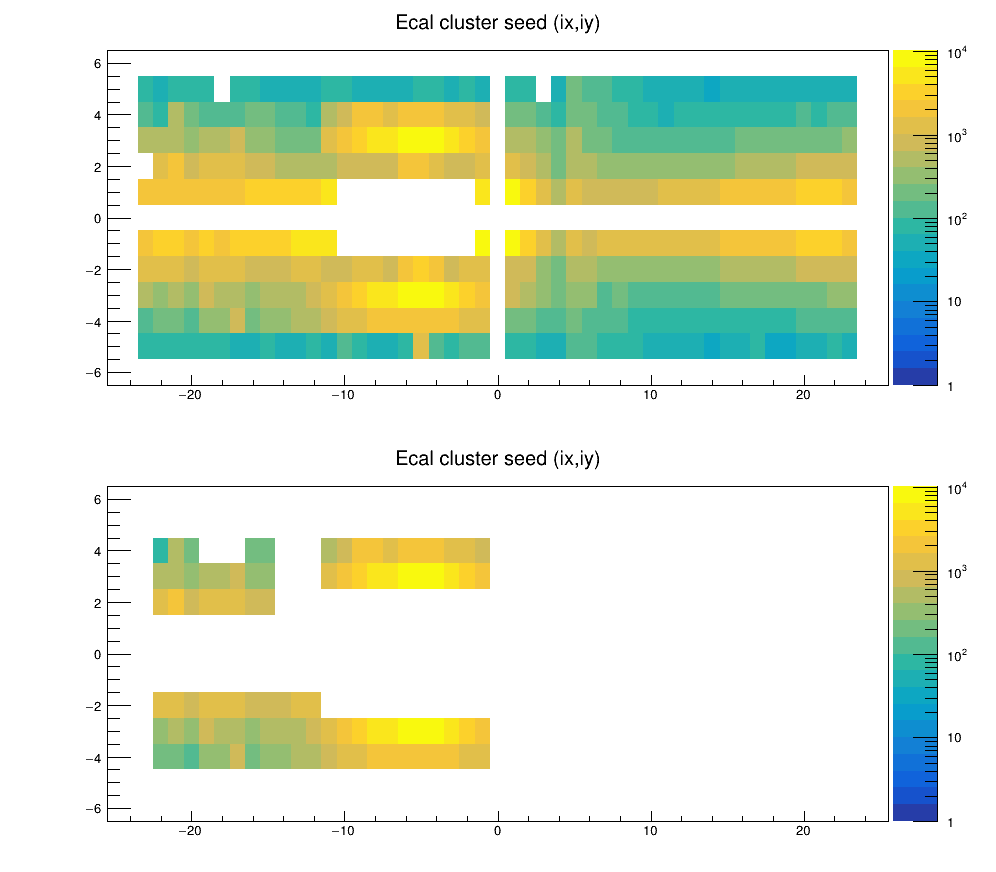

In [13]:
start = time.time()
c0 = R.TCanvas("c0","Canvas1",1000,900)
c0.Divide(1,2)
p1 = c0.cd(1)
p1.SetLogz(1)
h_ecal_loc.SetStats(0)
h_ecal_loc.Draw("colz")
p2 = c0.cd(2)
p2.SetLogz(1)
h_ecal_loc_fid.SetStats(0)
h_ecal_loc_fid.Draw("colz")
c0.Draw()
print(f"Execution time: {time.time() - start: 7.4f} secs.")

These two graphs show the effect of the chosen fiducical cuts. We cut on the electron size ($x < 0$) of the calorimeter and remove all clusters with seed crystals that do not have the full 8 neighboring crystals.

Graphs of the cluster energy for the FEE selection cuts. The left plot shows the ECAL cluster energy for various cuts with log-y. The right plot shows linear y, with the graph for the cut 'one cluster in the event' scaled by a factor or 7, to compare the shapes of the two curves. 


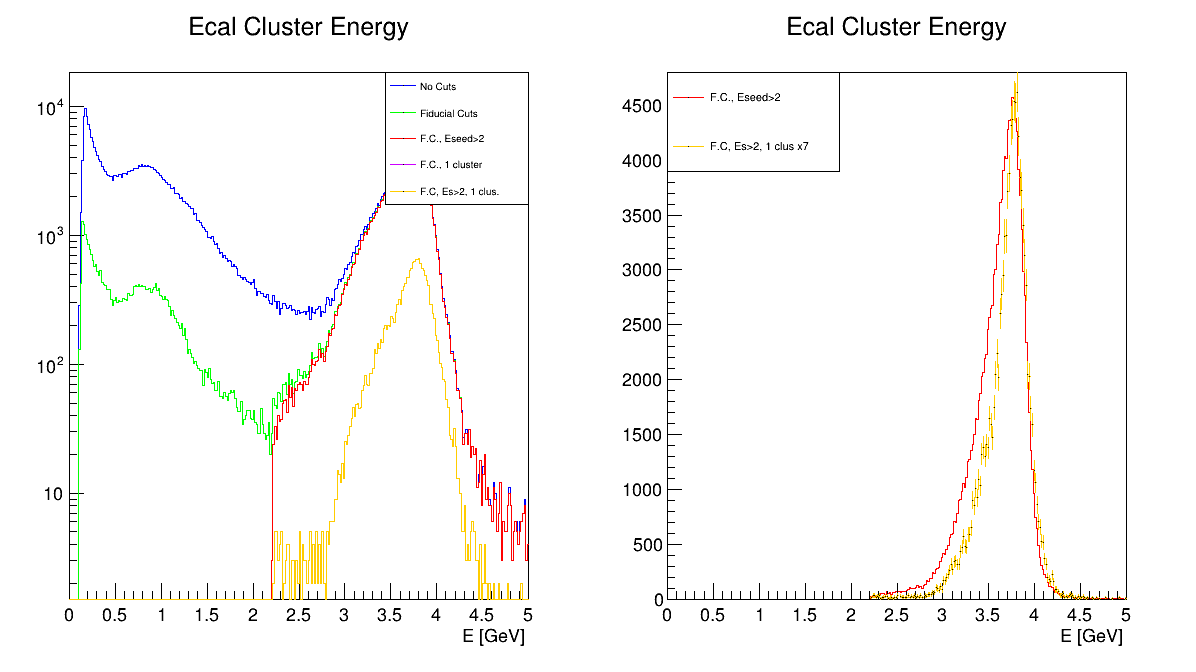

In [14]:
print("Graphs of the cluster energy for the FEE selection cuts. The left plot shows the ECAL cluster energy for various cuts with log-y. The right plot shows linear y, with the graph for the cut 'one cluster in the event' scaled by a factor or 7, to compare the shapes of the two curves. ")
c1 = R.TCanvas("c1","Canvas1",1200,700)
R.gStyle.SetOptStat(0)
c1.Divide(2,1)
p1 = c1.cd(1)
p1.SetLogy(1)
h_ecal_cluster_energy.SetLineColor(R.kBlue)
h_ecal_cluster_energy.Draw()
#h_ecal_cluster_energy_1.SetLineColor(R.kRed)
#h_ecal_cluster_energy_1.Draw("same")
h_ecal_cluster_energy_fid.SetLineColor(R.kGreen)
h_ecal_cluster_energy_fid.Draw("same")
h_ecal_cluster_energy_fid_e.SetLineColor(R.kRed)
h_ecal_cluster_energy_fid_e.Draw("same")
h_ecal_cluster_energy_fid_n.SetLineColor(R.kViolet)
h_ecal_cluster_energy_fid_n.Draw("same")
h_ecal_cluster_energy_fid_n_e.SetLineColor(R.kOrange)
h_ecal_cluster_energy_fid_n_e.Draw("same")
leg1 = R.TLegend(0.65,0.7,0.9,0.9)
leg1.AddEntry(h_ecal_cluster_energy.GetValue(), "No Cuts")
leg1.AddEntry(h_ecal_cluster_energy_fid.GetValue(),"Fiducial Cuts")
leg1.AddEntry(h_ecal_cluster_energy_fid_e.GetValue(),"F.C., Eseed>2")
leg1.AddEntry(h_ecal_cluster_energy_fid_n.GetValue(),"F.C., 1 cluster")
leg1.AddEntry(h_ecal_cluster_energy_fid_n_e.GetValue(),"F.C, Es>2, 1 clus.")
leg1.Draw()
p2 = c1.cd(2)
p2.SetLogy(0)
h_ecal_cluster_energy_fid_n_e_copy =  h_ecal_cluster_energy_fid_n_e.GetValue().Clone("h_ecal_cluster_energy_fid_n_e_copy")
h_ecal_cluster_energy_fid_n_e_copy.Scale(7)
h_ecal_cluster_energy_fid_e.Draw()
h_ecal_cluster_energy_fid_n_e_copy.Draw("same")
leg1_2 = R.TLegend(0.1,0.75,0.4,0.9)
leg1_2.AddEntry(h_ecal_cluster_energy_fid_e.GetValue(),"F.C., Eseed>2")
leg1_2.AddEntry(h_ecal_cluster_energy_fid_n_e.GetValue(),"F.C, Es>2, 1 clus x7")
leg1_2.Draw()
#h_ecal_cluster_energy_1_fid.SetLineColor(R.kOrange)
#h_ecal_cluster_energy_1_fid.Draw("same")
c1.Draw()

The one cluster in the event requirement is not used for the rest of the plots.
Here we plot the cluster energy for cuts on the number of ECAL hits in the event. There seems to be a variation of the centroid of the peaks for different N-hits in the cluster.


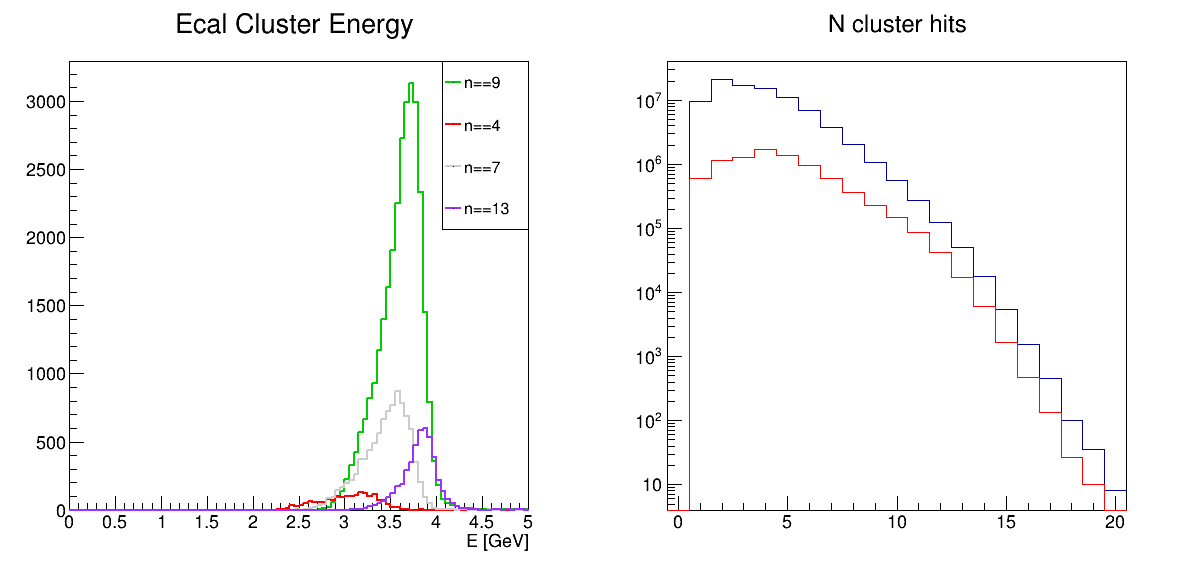

In [15]:
print("The one cluster in the event requirement is not used for the rest of the plots.")
print("Here we plot the cluster energy for cuts on the number of ECAL hits in the event. There seems to be a variation of the centroid of the peaks for different N-hits in the cluster.")
c2 = R.TCanvas("c2","Canvas1",1200,600)
c2.Divide(2,1)
p1 = c2.cd(1)
p1.SetLogy(0)
line_colors = [R.kBlack,   R.kBlue,   R.kGreen,   R.kOrange,   R.kRed,   R.kTeal,   R.kViolet,
               R.kGray,    R.kBlue+1, R.kGreen+1, R.kOrange+1, R.kRed+1, R.kTeal+1, R.kViolet+1,
               R.kGray+1,  R.kBlue+2, R.kGreen+2, R.kOrange+2, R.kRed+2, R.kTeal+2, R.kViolet+2]
leg2 = R.TLegend(0.75,0.6,0.9,0.9)
max=0
ii=0
for i in range(len(h_ecal_cluster_e_fid_np)):
    if h_ecal_cluster_e_fid_np[i].GetMaximum() > max:
        max = h_ecal_cluster_e_fid_np[i].GetMaximum()
        ii = i
# h_ecal_cluster_e_fid_np[ii].Draw()
for i in [9,4, 7,13]: # range(3,min(14,len(h_ecal_cluster_e_fid_np))):
    h_ecal_cluster_e_fid_np[i].SetStats(0)
    h_ecal_cluster_e_fid_np[i].SetLineWidth(2)
    h_ecal_cluster_e_fid_np[i].SetLineColor(line_colors[i])
    h_ecal_cluster_e_fid_np[i].Draw("same")
    leg2.AddEntry(h_ecal_cluster_e_fid_np[i].GetValue(), f"n=={i}")
leg2.Draw()

p2 = c2.cd(2)
p2.SetLogy(1)
h_ecal_cluster_nhits.Draw()
h_ecal_cluster_nhits_f.SetLineColor(R.kRed)
h_ecal_cluster_nhits_f.Draw("same")
leg2_2 = R.TLegend(0.75,0.6,0.9,0.9)
leg2_2.AddEntry(h_ecal_cluster_nhits.GetValue(),"No cuts")
leg2_2.AddEntry(h_ecal_cluster_nhits_f.GetValue(),"Fid Cuts")

c2.Draw()

Plot of the cluster seed on the ECAL (ix,iy) grid, for fiducial clusters that have a seed energy > 2 GeV and have N-hits >= 9


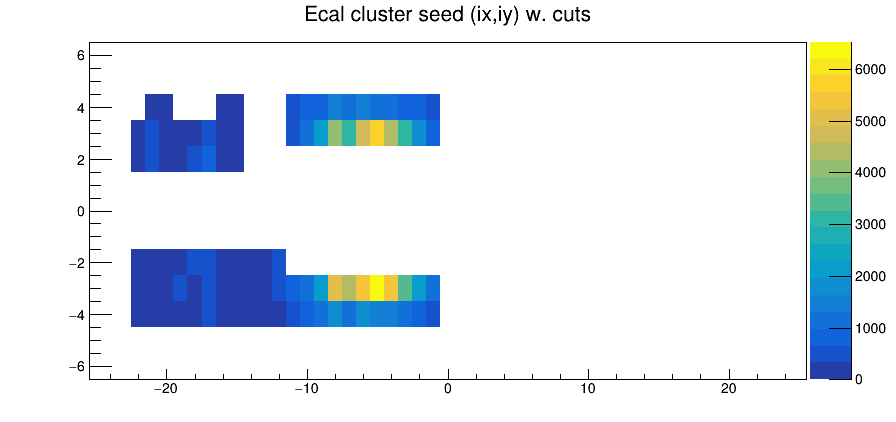

In [16]:
print("Plot of the cluster seed on the ECAL (ix,iy) grid, for fiducial clusters that have a seed energy > 2 GeV and have N-hits >= 9")
c4 = R.TCanvas("c4","Canvas4",900,450)
h2d.Draw("colz")
c4.Draw()

In [17]:
fit_f1 = R.TF1("fit_f1",R.fit_gaus_tailn,1.,5.,4)
fit_f2 = R.TF1("fit_f2",R.fit_gaus_tailn,1.,5.,4)

Execution time:  0.0241 secs.


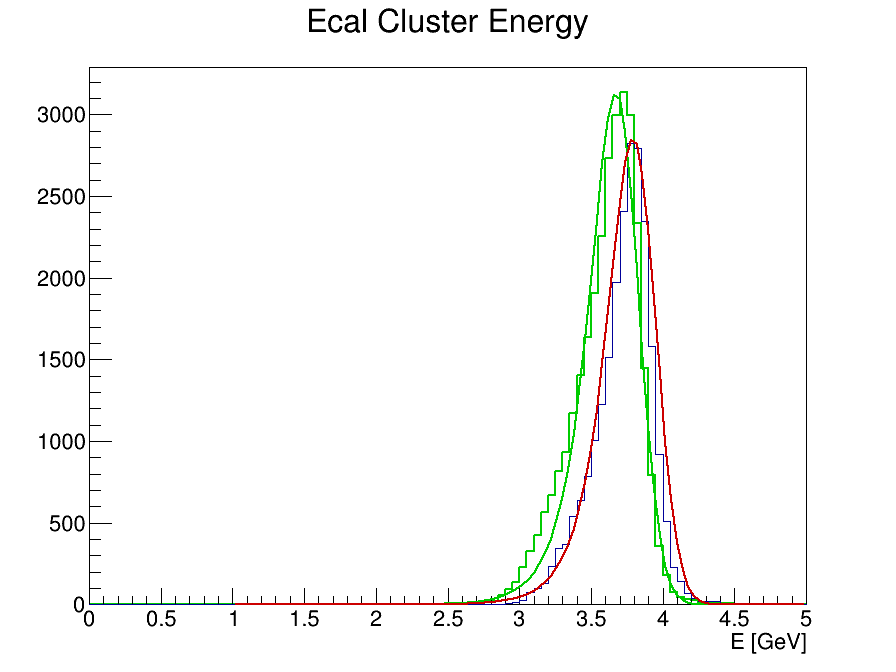

In [18]:
start = time.time()
fit_f1.SetParNames("Const","mu","sigma","lambda")
fit_f1.SetParameters(1428,3.78,0.133,6.09)
#fit_f1.FixParameter(3,5.)
#fit_f1.FixParameter(2,0.1)
fit_f1.SetLineColor(line_colors[9])
fit_f2.SetParNames("Const","mu","sigma","lambda")
fit_f2.SetParameters(1300,3.9,0.133,6.09)
fit_f2.SetLineColor(line_colors[11])
hh1 = h_ecal_cluster_e_fid_np[9].GetValue().Clone("hh1")
hh2 = h_ecal_cluster_e_fid_np[11].GetValue().Clone("hh2")
c5 = R.TCanvas("c5","Canvas5",900,700)
hh1.Draw()
hh2.Draw("same")
fit_f1.Draw("same")
fit_f2.Draw("same")
#hh1.Fit("fit_f1","S")
#hh2.Fit("fit_f2","S")
c5.Draw()
print(f"Execution time: {time.time() - start: 7.4f} secs.")

In [19]:
f = R.TFile("histograms_tmp.root","RECREATE")
hh1.Write()
hh2.Write()
f.Close()

In [20]:
# h2d  = dfx.Define("ecs_ix_f_e","RVec<int> out;for(size_t i=0; i<cluster_is_fiducial.size();++i){ if(cluster_is_fiducial[i] && ecal_cluster_seed_energy[i]>= 2. && ecal_cluster_nhits[i] >= 10 && ecal_cluster_nhits[i] <= 12 ) out.push_back(ecal_cluster_seed_ix[i]);}; return out;")\
#         .Define("ecs_iy_f_e","RVec<int> out;for(size_t i=0; i<cluster_is_fiducial.size();++i){ if(cluster_is_fiducial[i] && ecal_cluster_seed_energy[i]>= 2. && ecal_cluster_nhits[i] >= 9  ) out.push_back(ecal_cluster_seed_iy[i]);}; return out;")\
#     .Histo2D(("h2d","Ecal cluster seed (ix,iy) w. cuts",51,-25.5,25.5,13,-6.5,6.5),"ecs_ix_f_e","ecs_iy_f_e")


Same plot as before, but now an additional cut removes clusters with seeds in row iy= ±3 with ix in [-8, -3] for the thin line curves. These histogtams are then scaled by 2.5 and 2.4 to match the height by eye. The shape of the peaks did not change substantially, so probably the dominant region does not behave different from the rest of the ECAL.


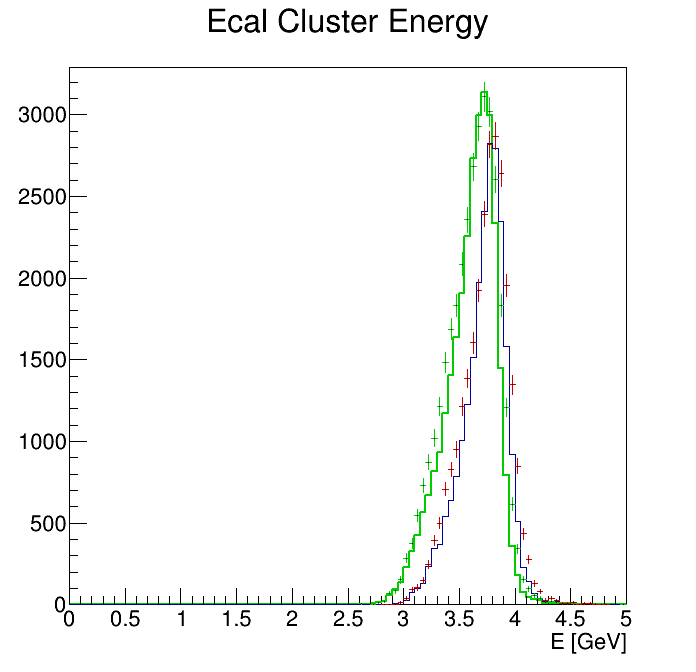

In [21]:
print("Same plot as before, but now an additional cut removes clusters with seeds in row iy= ±3 with ix in [-8, -3] for the thin line curves. These histogtams are then scaled by 2.5 and 2.4 to match the height by eye. The shape of the peaks did not change substantially, so probably the dominant region does not behave different from the rest of the ECAL.")
hh3 = h_ecal_cluster_e_fid_np_x[9].GetValue().Clone("hh3")
hh4 = h_ecal_cluster_e_fid_np_x[11].GetValue().Clone("hh4")
hh3.SetLineColor(line_colors[9])
hh4.SetLineColor(line_colors[11])
hh3.Scale(2.5)
hh4.Scale(2.4)
c6 = R.TCanvas("c6","Canvas3",700,700)
hh1.Draw()
hh2.Draw("same")
hh3.Draw("same")
hh4.Draw("same")
c6.Draw()